<a href="https://colab.research.google.com/github/sturu1/Mon-AM/blob/master/2020_07_17_%EC%98%A4%ED%9B%84%EC%88%98%EC%97%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 초고해상도 이미지 얻기 P355

고해상도 영상 복원 기술 Super Resolution

In [31]:
import pathlib
import PIL.Image as Image
import matplotlib.pyplot as plt
import tensorflow as tf

In [32]:
tf.keras.utils.get_file('/content/bsd_images.zip', 'http://bit.ly/35pHZlC', extract=True)

37527552/37520292 [==============================] - 0s 0us/step


'/content/bsd_images.zip'

In [33]:
!unzip /content/bsd_images.zip

Archive:  /content/bsd_images.zip
   creating: images/
   creating: images/test/
  inflating: images/test/100007.jpg  
  inflating: images/test/100039.jpg  
  inflating: images/test/100099.jpg  
  inflating: images/test/10081.jpg   
  inflating: images/test/101027.jpg  
  inflating: images/test/101084.jpg  
  inflating: images/test/102062.jpg  
  inflating: images/test/103006.jpg  
  inflating: images/test/103029.jpg  
  inflating: images/test/103078.jpg  
  inflating: images/test/104010.jpg  
  inflating: images/test/104055.jpg  
  inflating: images/test/105027.jpg  
  inflating: images/test/106005.jpg  
  inflating: images/test/106047.jpg  
  inflating: images/test/107014.jpg  
  inflating: images/test/107045.jpg  
  inflating: images/test/107072.jpg  
  inflating: images/test/108004.jpg  
  inflating: images/test/108036.jpg  
  inflating: images/test/108069.jpg  
  inflating: images/test/109055.jpg  
  inflating: images/test/112056.jpg  
  inflating: images/test/112090.jpg  
  infla

In [34]:
image_root = pathlib.Path('/content/images')
all_images_paths=list(image_root.glob('*/*'))
print(all_images_paths[:10])

[PosixPath('/content/images/test/81066.jpg'), PosixPath('/content/images/test/257098.jpg'), PosixPath('/content/images/test/120093.jpg'), PosixPath('/content/images/test/196040.jpg'), PosixPath('/content/images/test/134049.jpg'), PosixPath('/content/images/test/108036.jpg'), PosixPath('/content/images/test/268074.jpg'), PosixPath('/content/images/test/163096.jpg'), PosixPath('/content/images/test/103006.jpg'), PosixPath('/content/images/test/156054.jpg')]


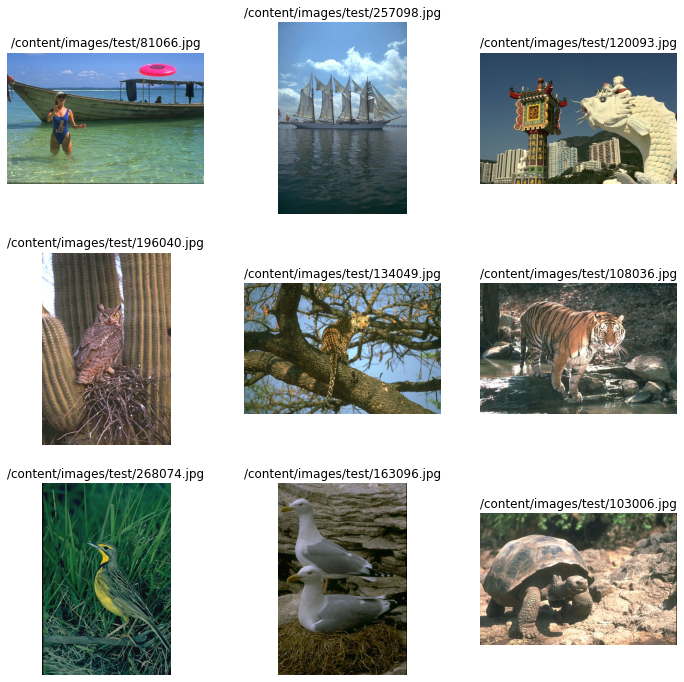

In [35]:
plt.figure(figsize=(12, 12))
for c in range(9):
  plt.subplot(3,3,c+1)
  plt.imshow(plt.imread(all_images_paths[c]))
  plt.title(all_images_paths[c])
  plt.axis('off')
plt.show()

In [36]:
train_path = []
valid_path = []
test_path = []


for image_path in all_images_paths:
  if str(image_path).split('.')[-1] != 'jpg':
    continue #무시

#content/images/train
  if str(image_path).split('/')[3] == 'train':
    train_path.append(str(image_path))
  elif str(image_path).split('/')[3] == 'val':
    valid_path.append(str(image_path))
  else:
    test_path.append(str(image_path))

print(len(train_path), len(valid_path), len(test_path))

200 100 200


In [37]:
import tensorflow as tf

def get_hr_and_lr(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

#어떤 이미지를 어떤 크기로 자를 것인가?
#랜덤한 위치에서 50, 50 크기로 가져옴
  hr = tf.image.random_crop(img, [50, 50, 3])
  lr = tf.image.resize(hr, [25, 25])#해상도 절반으로 저하
  lr = tf.image.resize(lr, [50, 50])#다시 강제로 2배로 키움
  return lr, hr

In [38]:
# 훈련 및 검증 데이터셋을 정의
#file 경로를 Dataset라이브러리에 저장해줌
train_dataset = tf.data.Dataset.list_files(train_path)
#내부에 설정된 파일결로가 자동으로 get hr and lr 함수의 인자로 들어가서 데이터 쌍을 맵핑함
train_dataset = train_dataset.map(get_hr_and_lr)
# #데이터 반복, 보통 epoch의 수와 동일, 아무것도 인자로 넣지 않으면 계속 반복됨
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(16)

valid_dataset = tf.data.Dataset.list_files(valid_path)
valid_dataset = valid_dataset.map(get_hr_and_lr)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(16)

# REDNet

차이를 학습한다. = Residual

Residual

In [39]:
import tensorflow as tf
#num_layers REDNet-20, 30 네트워크 구조에 다라 넣을 수 잇음
#REDNet-30 인 경우 15를 넣고, REDNet-20인 경우 10을 넣으면 됨
#Conv 개수와 Deconv개수가 동일하므로 2로 나눈 레이어 개수만큼만 넣으면 됨
def REDNet(num_layers):
  conv_layers = []
  deconv_layers = []
  residual_layers = []
#입력 레이어 정의 : None으로 해놓으면 임의의 차원을 모두  입력으로 받을 수 있음
  inputs = tf.keras.layers.Input(shape=(None, None, 3))
#처음 입력영상 처리하는 부분은 3채널로써 먼저 con layer하나를 미리 담아준다.
  conv_layers.append(tf.keras.layers.Conv2D(3, kernel_size=3, padding='same', activation='relu'))

  for i in range(num_layers-1):#0~13, 14번
    conv= tf.keras.layers.Conv2D(64, kernel_size=3, padding='same',activation='relu')#convolution
    deconv=  tf.keras.layers.Conv2DTranspose(64, kernel_size=3, padding='same',activation='relu')#deconvolution

    conv_layers.append(conv)#conv 레이어 적재
    deconv_layers.append(deconv)#deconv 레이어 적재

  deconv_layers.append(tf.keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same'))#채널이 3개이니깐 3임

#  총 30개의 레이어 오브젝트가 준비되었음

# 인코딩 path 연결을 시작
  x = conv_layers[0](inputs)#빨간색 #첫번째 레이어 먼저 처리
  
  for i in range(num_layers-1):# 0~13
    x = conv_layers[i+1](x)#conv 레이어들 쭉쭉 연결
    
    if i % 2 == 0: #짝
    #slip connection으로 나중에 deconvolution할떄 연결해주기위해서 중간 값들을 저장함.
      residual_layers.append(x)
#디코딩할때는 최근 인코딩한거부터 시작됨

  #디코딩 path연결 시작
  for i in range(num_layers-1):#0~13
    if i % 2 == 1:
      x = tf.keras.layers.Add()([x, residual_layers.pop()])#pop은 가장 마지막에 들어갔던 순서로 꺼냄
      x = tf.keras.layers.Activation('relu')(x)#P363그림으로 확인가능

    x = deconv_layers[i](x)#Deconvolution 항상하는것

  x = deconv_layers[-1](x)

  model = tf.keras.Model(inputs=inputs, outputs=x)
  return model

In [40]:
def psnr_metric(y_true, y_pred):
  return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [43]:
model = REDNet(15)
model.compile(optimizer = tf.optimizers.Adam(0.0001), loss='mse', metrics=[psnr_metric])
model.summary()
#train_dataset이 휘발성이 있어서 처음부터 재생한 후 해보기
history=model.fit_generator(train_dataset, epochs=500, steps_per_epoch=len(train_path)//16, validation_data = valid_dataset, validation_steps = len(valid_path), verbose=2)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_137 (Conv2D)             (None, None, None, 3 84          input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_138 (Conv2D)             (None, None, None, 6 1792        conv2d_137[0][0]                 
__________________________________________________________________________________________________
conv2d_139 (Conv2D)             (None, None, None, 6 36928       conv2d_138[0][0]                 
____________________________________________________________________________________________

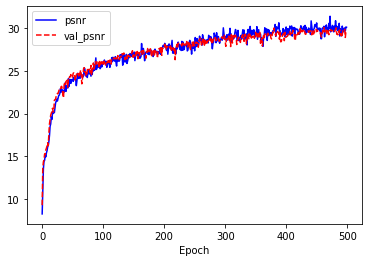

In [44]:
 plt.plot(history.history['psnr_metric'], 'b-', label='psnr')
 plt.plot(history.history['val_psnr_metric'], 'r--', label='val_psnr')
 plt.xlabel('Epoch')
 plt.legend()
 plt.show()

In [62]:
import numpy as np

img = tf.io.read_file(test_path[16])
img = tf.image.decode_jpeg(img, channels=3)
hr = tf.image.convert_image_dtype(img, tf.float32)

lr = tf.image.resize(hr, [hr.shape[0]//2, hr.shape[1]//2])
lr = tf.image.resize(lr, [hr.shape[0], hr.shape[1]])
predict_hr=model.predict(np.expand_dims(lr, axis=0))

print(tf.image.psnr(np.squeeze(predict_hr, axis=0), hr, max_val=1.0))
print(tf.image.psnr(lr, hr, max_val=1.0))

tf.Tensor(27.12968, shape=(), dtype=float32)
tf.Tensor(26.52611, shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


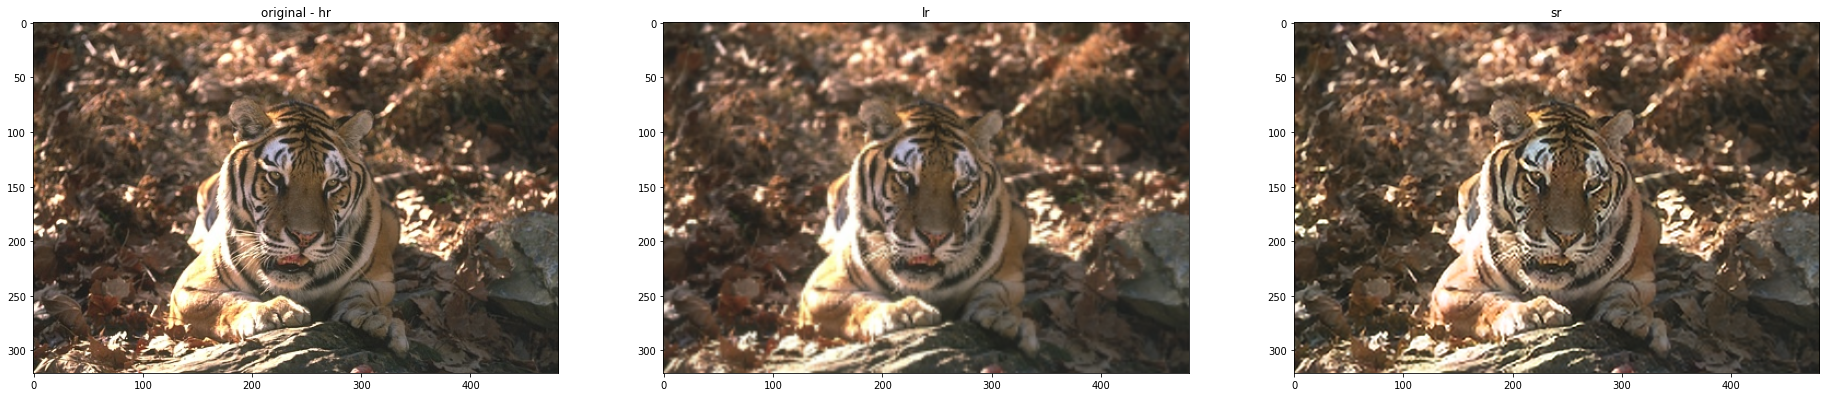

In [63]:
plt.figure(figsize=(32,8))
plt.subplot(1,3,1)
plt.imshow(hr)
plt.title('original - hr')

plt.subplot(1,3,2)
plt.imshow(lr)
plt.title('lr')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(predict_hr, axis=0))
plt.title('sr')

plt.show()

https://chloevan.github.io/python/tensorflow2.0/ch9_4_super_resolution/#ii-rednet1

# U-Net

![대체 텍스트](https://miro.medium.com/max/700/1*qNdglJ1ORP3Gq77MmBLhHQ.png)

## PSNR 측정방법 P367

최대신호대 잡음비(PSNR)
- 영상 또는 동영상 손실 압축에서 화질 손실 정보를 평가할 때 사용

30정도면 된다

Max 는 255